# Exploratory Data Analysis (EDA) Notebook Overview

This notebook performs an exploratory data analysis (EDA) on the **Loan_Data.csv** dataset. The primary objective is to understand the dataset's structure, identify any underlying patterns, detect outliers, and visualize the relationships between different variables. This analysis is particularly useful for developing predictive models for loan default risk and potential fraud detection.

In [1]:
import pandas as pd 
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading and Overview

The analysis begins by loading the dataset and providing an overview of its structure:

- The dataset contains 10,000 entries with 8 columns, representing various financial and credit-related attributes of customers.
- It includes information such as outstanding loans, total debt, income, years employed, FICO score, and whether a customer has defaulted on a loan (the target variable).

In [2]:
print("------------------ Loan_Data.csv ------------------\n")
df = pd.read_csv('../data/raw/Loan_Data.csv')
df.info()

------------------ Loan_Data.csv ------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


1. **customer_id**:                 A unique identifier for each customer.
2. **credit_lines_outstanding**:    The number of active credit lines the customer has.
3. **loan_amt_outstanding**:        The total amount of outstanding loans for the customer.
4. **total_debt_outstanding**:      The total amount of debt the customer owes.
5. **income**:                      The customer's annual income (float).
6. **years_employed**:              The number of years the customer has been employed.
7. **fico_score**:                  The customer's FICO credit score, indicating their creditworthiness.
8. **default**:                     A binary indicator (0 or 1) showing whether the customer has defaulted on a loan, or not.

All columns have non-null values, with data types including integers and floats. 

## Target
The `default` column indicates whether the customer has defaulted on their loan:

- **`default = 1`**: The customer has defaulted on their loan, which could be associated with fraudulent behavior.
- **`default = 0`**: The customer has not defaulted, so there is no indication of fraud based on this column.

This binary indicator allows to identify and analyze instances of loan defaults, which may be useful for detecting patterns or predicting potential fraud.

## Normality Check of Continuous Variables

A function, `check_normality()`, is defined to assess the normality of each numeric column in the dataset using statistical tests (Shapiro-Wilk or D'Agostino-Pearson, depending on the sample size). This is important for selecting appropriate statistical methods for analysis:

- The results indicate that most variables do not follow a normal distribution, except for the `income` variable.

In [3]:
def check_normality(df, alpha=0.05):
    results = {}
    for column in df.columns:
        if df[column].dtype in [np.int64, np.float64]:
            data = df[column].dropna()
            n = len(data)
            
            if data.nunique() <= 1:  # Check for constant 
                results[column] = {'p-value': np.nan, 'Normality': 'Constant or Insufficient Variance'}
                continue
            
            if n > 5000:                                # Use a normality test based on sample size
                stat, p_value = stats.normaltest(data)      # Use D'Agostino-Pearson test for large samples
            else:
                stat, p_value = stats.shapiro(data)         # Use Shapiro-Wilk test for small samples
            
            p_value = max(min(p_value, 1), 0)               # Ensure p-value is within [0, 1]
            
            normality = 'Normal' if p_value > alpha else 'Not Normal'
            results[column] = {'p-value': p_value, 'Normality': normality}
    
    return pd.DataFrame.from_dict(results, orient='index')

normality_results = check_normality(df)
print(normality_results)

                                p-value   Normality
customer_id                0.000000e+00  Not Normal
credit_lines_outstanding  7.240646e-285  Not Normal
loan_amt_outstanding       1.039033e-67  Not Normal
total_debt_outstanding     0.000000e+00  Not Normal
income                     3.442481e-01      Normal
years_employed             1.371199e-03  Not Normal
fico_score                 3.489325e-03  Not Normal
default                    0.000000e+00  Not Normal


## Visualizing Relationships with Pair Plots

The `plot_pairplot()` function generates pair plots to visualize the relationships between variables, colored by the `default` status:

- The pair plot helps in identifying the separation between classes (defaulted vs. non-defaulted loans) and potential linear or non-linear relationships between variables.

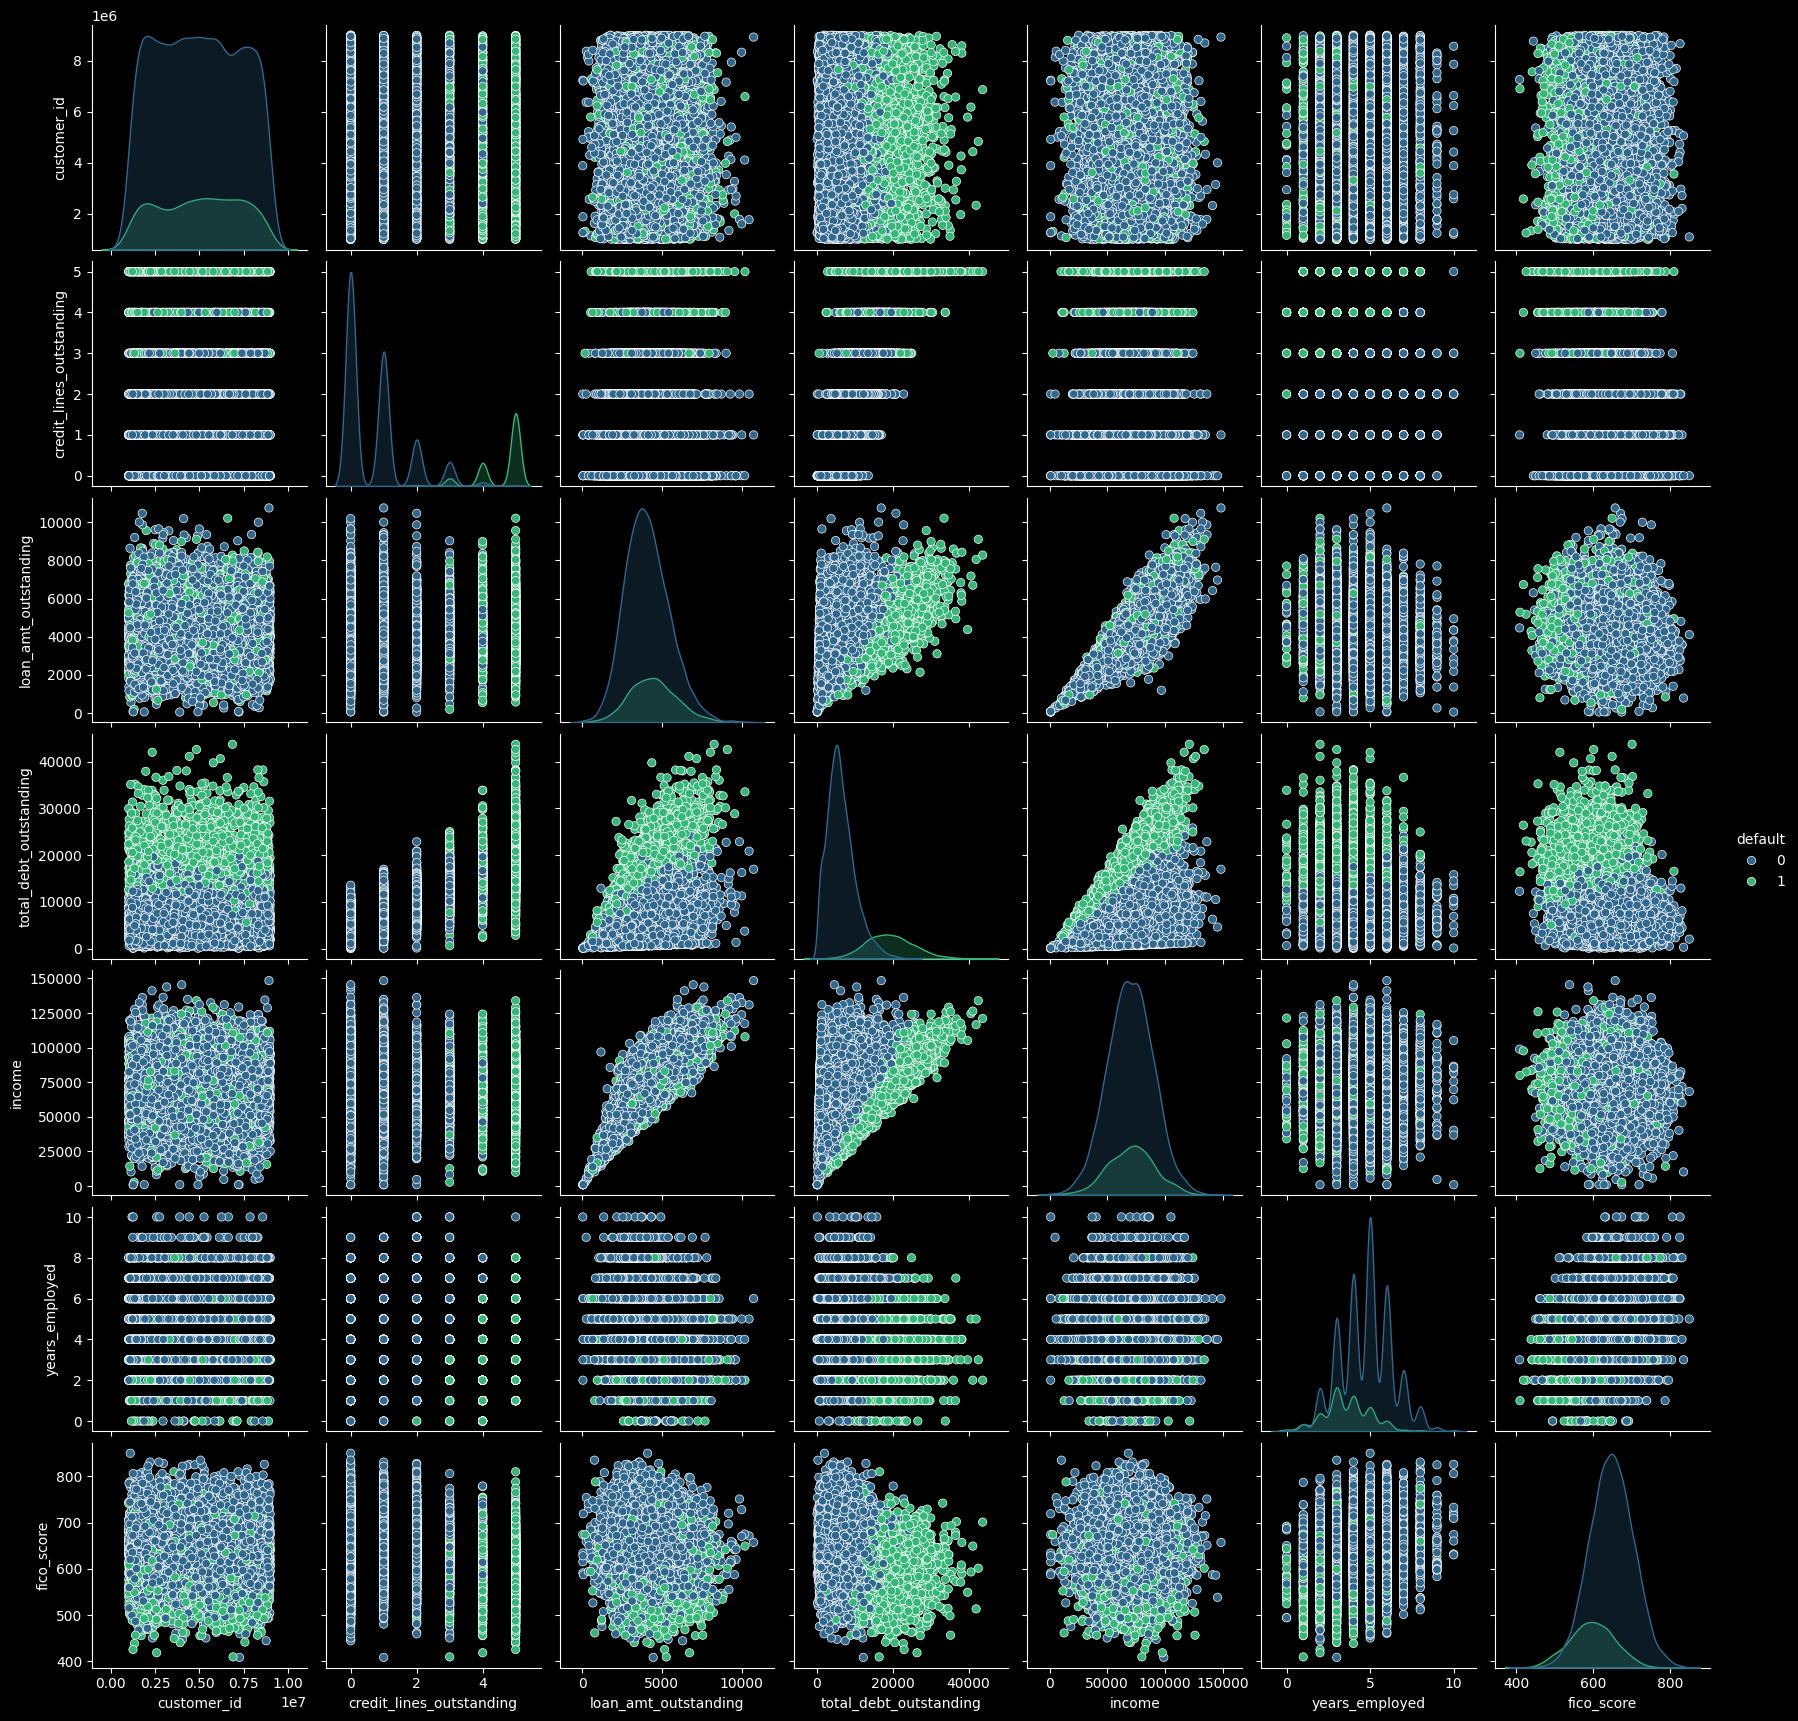

In [4]:
def plot_pairplot(df):
    df['default'] = df['default'].astype('category')
    plt.style.use('dark_background')
    pairplot = sns.pairplot(df, hue='default', palette='viridis', diag_kind='kde')
    plt.show()

plot_pairplot(df)

## Class Imbalance

The `check_class_imbalance()` function checks for class imbalance in the `default` variable:

- The results show an imbalance, with 81.49% of the observations belonging to class `0` (no default) and only 18.51% belonging to class `1` (default). This class imbalance may need to be addressed in future modeling to ensure balanced predictive performance.

In [5]:
def check_class_imbalance(df, column='default'):
    class_counts = df[column].value_counts()
    class_percentages = (class_counts / len(df)) * 100
    
    print("Class distribution in column '{}':".format(column))
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} occurrences ({class_percentages[cls]:.2f}%)")

check_class_imbalance(df)

Class distribution in column 'default':
Class 0: 8149 occurrences (81.49%)
Class 1: 1851 occurrences (18.51%)


## Outlier Detection
Outliers are detected using two methods: **Interquartile Range (IQR)** and **Z-score**:

- The `detect_missing_and_outliers()` function identifies outliers for each numeric column and visualizes them using box plots and scatter plots.
- Common outliers identified by both methods are highlighted, which could represent potential errors or anomalies in the data.

Missing values by column:
 Series([], dtype: int64)

Outliers for loan_amt_outstanding:


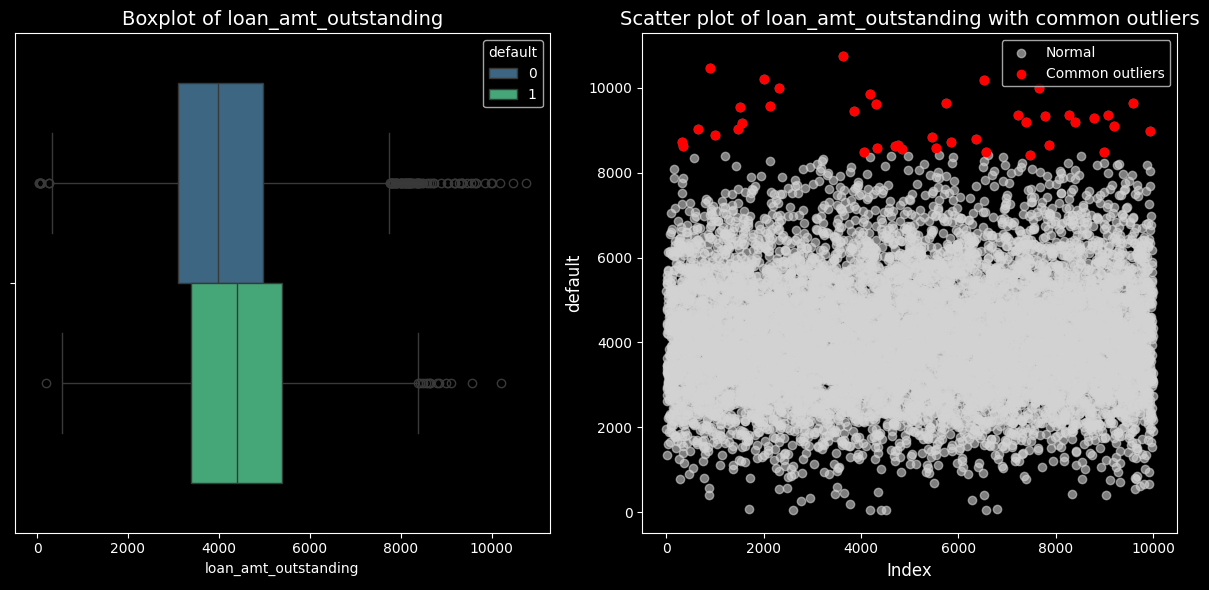


Outliers for total_debt_outstanding:


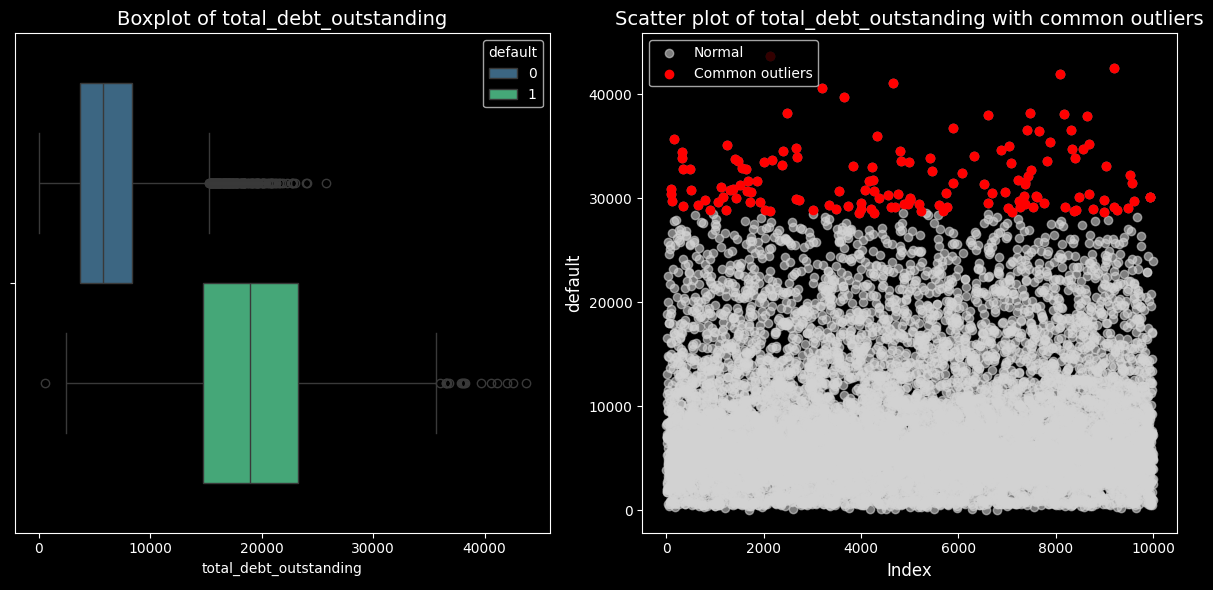


Outliers for income:


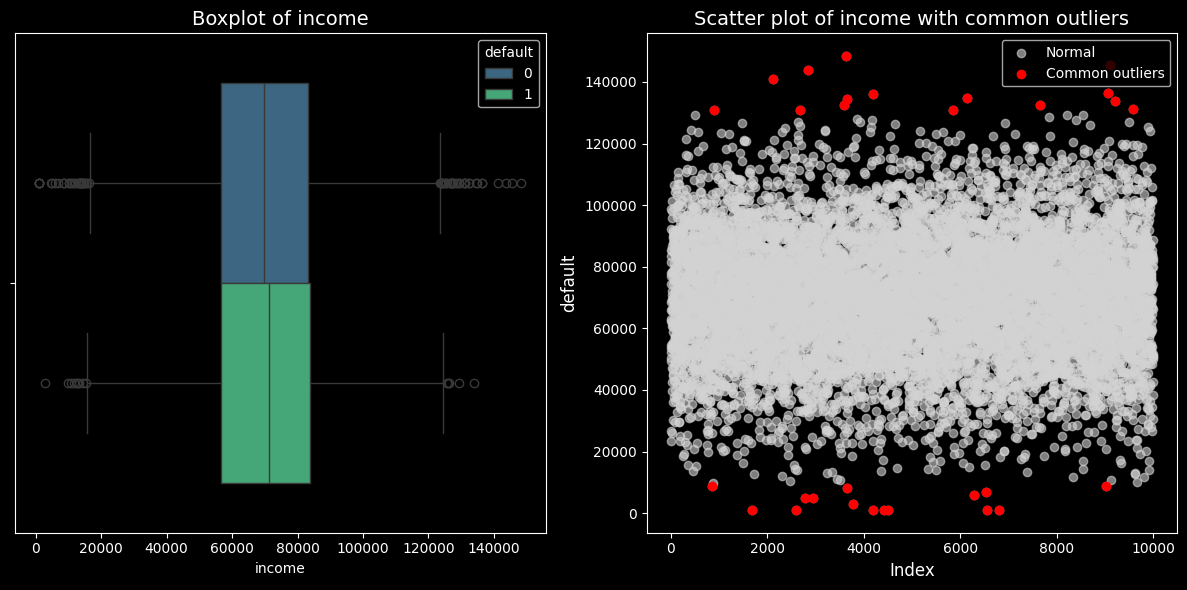


Outliers for fico_score:


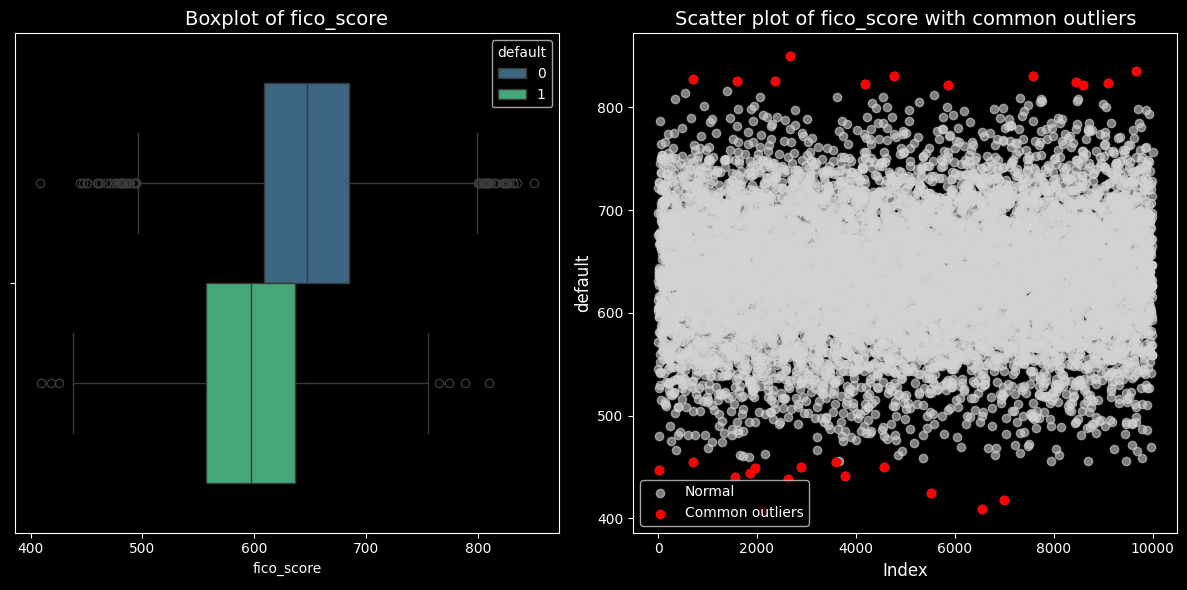

In [6]:
def detect_missing_and_outliers(df):
    
    missing_values = df.isnull().sum()
    print("Missing values by column:\n", missing_values[missing_values > 0])
    
    iqr_outliers = {}
    z_score_outliers = {}
    
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        
        Q1 = df[column].quantile(0.25)      # IQR Method
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        iqr_outlier_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        iqr_outliers[column] = iqr_outlier_indices.tolist()
        
        z_scores = stats.zscore(df[column])                                     # Z-score Method
        z_outlier_indices = df[(z_scores > 3) | (z_scores < -3)].index
        z_score_outliers[column] = z_outlier_indices.tolist()
        
        common_outliers = set(iqr_outlier_indices).intersection(set(z_outlier_indices))     # IQR / Z-score common identification
        common_outliers = list(common_outliers)  

        if common_outliers:                         # Plot common identified outliers 
            print(f'\nOutliers for {column}:')
            plt.style.use('dark_background')
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)                                                                # Box plot (left)
            sns.boxplot(x=df[column], palette='viridis', hue=df['default'], legend=True)
            plt.title(f'Boxplot of {column}', fontsize=14, color='white')
            
            plt.subplot(1, 2, 2)                                                                # Scatter (right)
            plt.scatter(df.index, df[column], label='Normal', alpha=0.6, color='lightgray')
            plt.scatter(common_outliers, df.loc[common_outliers, column], color='red', label='Common outliers')
            plt.title(f'Scatter plot of {column} with common outliers', fontsize=14, color='white')
            plt.xlabel('Index', fontsize=12, color='white')
            plt.ylabel('default', fontsize=12, color='white')
            plt.legend()
            
            plt.tight_layout()
            plt.show()    

detect_missing_and_outliers(df)


## Correlation Analysis

The `plot_correlation_matrix_and_histogram()` function analyzes the correlations between variables:

- A correlation heatmap is generated to visualize relationships between all variables.
- A bar plot shows the correlation of each variable with the `default` variable, helping to identify which factors may be most predictive of loan defaults.

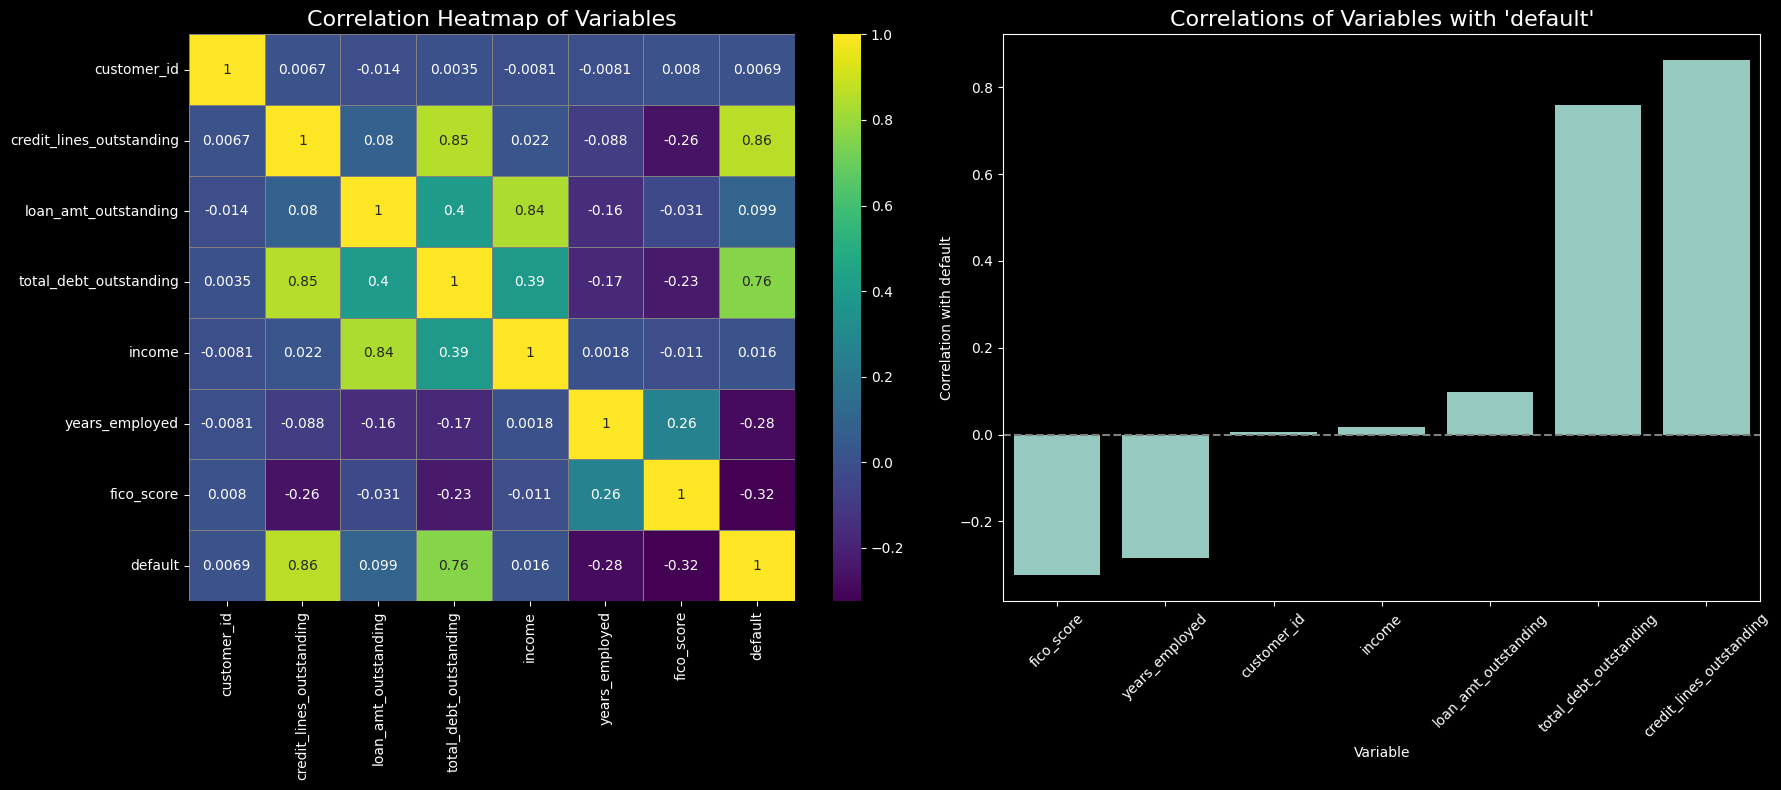

In [7]:
def plot_correlation_matrix_and_histogram(df):
    correlation_matrix = df.corr()
    
    corr_default = correlation_matrix['default'].drop('default')  
    
    corr_df = corr_default.reset_index()
    corr_df.columns = ['Variable', 'Correlation with default']
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.5, linecolor='gray', ax=axes[0])
    axes[0].set_title('Correlation Heatmap of Variables', fontsize=16, color='white')
    
    corr_df_sorted = corr_df.sort_values(by='Correlation with default')
    sns.barplot(x='Variable', y='Correlation with default', data=corr_df_sorted, ax=axes[1])
    axes[1].set_title('Correlations of Variables with \'default\'', fontsize=16, color='white')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].axhline(0, color='grey', linestyle='--')
    
    plt.tight_layout()
    plt.show()

plot_correlation_matrix_and_histogram(df)

## Summary

This EDA provides a comprehensive understanding of the data and prepares the groundwork for further analysis and modeling. Future steps might involve feature engineering, addressing class imbalance, and selecting appropriate modeling techniques based on the findings from this analysis.